# Get the Class names 

This file contains a subset of the quick draw classes. I choose 5 classes from the dataset. 

Read the classes names 

In [1]:
f = open("quickdraw_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [2]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [4]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/donut.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cookie.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/envelope.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/panda.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy


# Imports 

In [5]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [6]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [7]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [8]:
print(len(x_train))

16000


Show some random data 

cookie


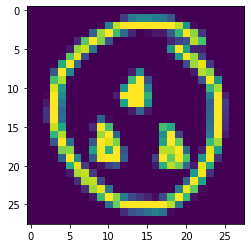

In [9]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [10]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [11]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(5, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

# Training 

In [12]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
57/57 - 12s - loss: 0.7838 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4224 - val_top_k_categorical_accuracy: 1.0000 - 12s/epoch - 213ms/step
Epoch 2/5
57/57 - 10s - loss: 0.3313 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2661 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 182ms/step
Epoch 3/5
57/57 - 10s - loss: 0.2466 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2344 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 179ms/step
Epoch 4/5
57/57 - 10s - loss: 0.2023 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2279 - val_top_k_categorical_accuracy: 1.0000 - 10s/epoch - 179ms/step
Epoch 5/5
57/57 - 11s - loss: 0.1783 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1778 - val_top_k_categorical_accuracy: 1.0000 - 11s/epoch - 192ms/step


# Testing 

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


# Inference 

1/1 [==============================] - 0s 17ms/step
['panda']


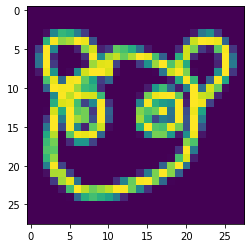

In [28]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:1]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [14]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [15]:
!pip install tensorflowjs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Save and Convert 

In [16]:
model.save('keras.h5')

In [17]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2022-12-06 02:47:38.117887: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-06 02:47:38.118008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-06 02:47:38.118026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Zip and Download 

In [18]:
!cp class_names.txt model/class_names.txt

In [19]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/class_names.txt (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 8%)
  adding: model/model.json (deflated 81%)


In [20]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>